[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DanielAlonsoBastos/AprendizajeProfundo/blob/main/tarea1-redes-densas/4_fcn.ipynb)

# 4. Red completamente conectada con PyTorch
Curso: Aprendizaje profundo

Alumno: Daniel Alonso

Implementa una red completamente conectada para la tarea de clasificación de imágenes sobre el conjunto de Fashion-MNIST, tomando en cuenta las siguiente especificaciones:
* Explora con diferentes número de neuronas, capas, funciones de activación e hiperparámetros.
* Discute tus resultados con las distintas configuraciones.
-----------------------

❗ El tiempo de ejecución del notebook completo es alto debido a la serie de experimentos que se realizan en el mismo.

# 1 Preparación

## 1.1 Bibliotecas

In [ ]:
!pip install torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import random
import time

# redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import FashionMNIST
import torchvision.transforms as T
from torchinfo import summary
# visualizacion
import matplotlib.pyplot as plt
from matplotlib import markers
from IPython import display
display.set_matplotlib_formats('svg')

# tomar n elementos de una secuencia
from itertools import islice as take

# barras de progreso
from tqdm.auto import trange

## 1.2 Auxiliares

In [ ]:
# directorio de datos
DATA_DIR = '../data'

# tamaño del lote
BATCH_SIZE = 32
# filas y columnas de la rejilla de imágenes
ROWS, COLS = 4, 8

def display_grid(xs, titles, rows, cols, figsize=(12, 6)):
  """Displays examples in a grid."""
  fig, ax = plt.subplots(rows, cols, figsize=figsize)
  i = 0
  for r in range(rows):
      for c in range(cols):
          ax[r, c].imshow(xs[i], cmap='gray')
          ax[r, c].set_title(titles[i])
          ax[r, c].set_xticklabels([])
          ax[r, c].set_yticklabels([])
          i += 1
  fig.tight_layout()
  plt.show()


def display_batch(x, titles, rows, cols, figsize=(12, 6)):
  """Displays a batch of processed examples in a grid."""
  # denormalizamos [0, 1] => [0, 255]
  x *= 255
  # rotamos canales (C x H x W) => (H x W x C)
  x = x.permute(0, 2, 3, 1)
  # convertimos a entero
  x = (x.numpy()).astype(np.uint8)
  # aplanamos canal
  x = x.reshape(*x.shape[:3])
  # desplegamos
  display_grid(x, titles, rows, cols, figsize)

    
def set_seed(seed=0):
  """Initializes pseudo-random number generators."""
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

    
# reproducibilidad
set_seed()

# 2 Datos

## 2.1 Descarga y visualización

PyTorch tiene la clase `FashionMINST` para poder emplear un conjunto de imágenes en escala de grises de 28x28 píxeles, que contienen 10 categorías distintas, etiquetadas por números:

0. Playera/top
1. Pantalón
2. Sudadera
3. Vestido
4. Abrigo
5. Sandalia
6. Camisa
7. Tenis
8. Bolso
9. Bota

El conjunto de entrenamiento cuenta con 60,000 imágenes, mientras que el conjunto de prueba cuenta con 10,000 imágenes.

In [ ]:
# creamos un Dataset
ds = FashionMNIST(
  # directorio de datos
  root=DATA_DIR,
  # subconjunto de entrenamiento
  train=True,
  # convertir la imagen a ndarray
  transform=np.array,
  # descargar el conjunto
  download=True
);

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



images[0] shape=(28, 28) dtype=uint8


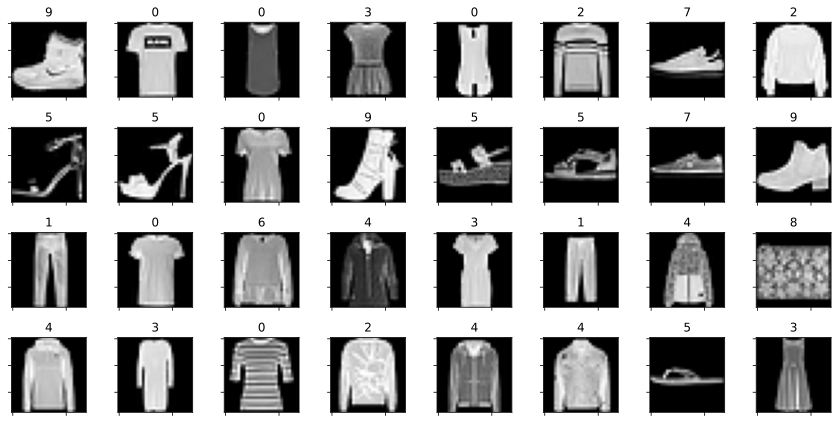

In [ ]:
# visualizacion de un conjunto de imagenes
images, labels = [], []
for i in range(BATCH_SIZE):
  x, y = ds[i]
  images.append(x)
  labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, ROWS, COLS)

## 2.2 Crear conjuntos de prueba y entrenamiento

In [ ]:
def build_dl(ds_train,ds_test,batch_size=32, shuffle=True):
  # generar dataloaders (dl) de un dataset (ds)
  dl_train = DataLoader(ds_train,batch_size=batch_size,shuffle=shuffle)
  dl_test = DataLoader(ds_test,batch_size=batch_size,shuffle=shuffle)
  return dl_train, dl_test

In [ ]:
# transformación que convierte una imagen:
#   de numpy.ndarray    (H x W x C) en rango [0, 255]
#   a torch.FloatTensor (C x H x W) en rango [0, 1]
tsfm = T.ToTensor()

# pytorch datasets
train_data = FashionMNIST(root = DATA_DIR,train = True,transform = tsfm)
test_data = FashionMNIST(root = DATA_DIR,train = False,transform = tsfm)

print(f'El conjunto de entrenamiento cuenta con {len(train_data)} imáganes')
print(f'El conjunto de prueba cuenta con {len(test_data)} imáganes')

train_loader, test_loader = build_dl(train_data,test_data,BATCH_SIZE)

El conjunto de entrenamiento cuenta con 60000 imáganes
El conjunto de prueba cuenta con 10000 imáganes


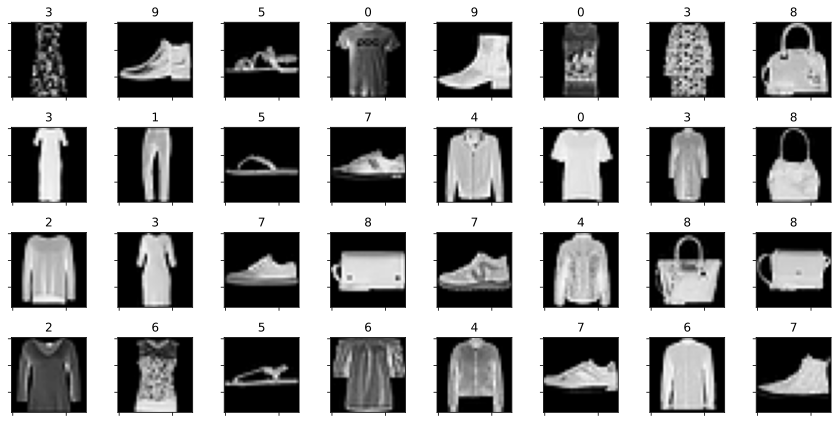

In [ ]:
# visualizacion de un lote de imagenes
x, y = next(iter(train_loader))
display_batch(x, y.tolist(), ROWS, COLS)

# 3 Modelo



## 3.1 Definición de la arquitectura

A continuación se define una función que regresa la arquitectura de una red completamente conectada, en dicha red se pueden variar el número de capas ocultas `n_layers`, el número de neuronas en las capas ocultas `n_neurons` y la función de activación entre ReLU, sigmoide y tanh. Se realizó empleando `ModuleDict` para tener la capacidad de realizar experimentos para variar la función de activación, el ancho y profundidad de la red.

In [ ]:
def create_FCN(n_layers=1, n_neurons=128, activation_function = 'ReLU'):
  '''
  Crear el modelo con los siguientes inputs:
  n_layers (int) - numero de capas ocultas en la red
  n_neurons (int) - numero de neuronas en la(s) capa(s) oculta(s)
  activation_function - funcion de activacion: ReLU, Sigmoid, tanh
  '''
  class FCN(nn.Module):
    def __init__(self,n_layers, n_neurons, activation_function):
      super().__init__() # inicializacion del objeto padre

      # seleccion de la funcion de activacion
      if activation_function == 'ReLU': self.activation = F.relu
      if activation_function == 'Sigmoid': self.activation = torch.sigmoid
      if activation_function == 'tanh': self.activation = torch.tanh
    
      # definicion de un diccionario para guardar las capas
      self.layers = nn.ModuleDict()

      # capa de entrada
      self.layers['flatten'] = nn.Flatten()
      self.layers['input'] = nn.Linear(1*28*28,n_neurons)

      # capas ocultas
      for i in range(n_layers):
        self.layers[f'hidden{i}'] = nn.Linear(n_neurons, n_neurons)

      # capa de salida
      self.layers['output'] = nn.Linear(n_neurons,10)

    def forward(self,x):
      # entrada
      x = self.layers['flatten'](x)
      x = self.activation(self.layers['input'](x))
      # capas ocultas
      for i in range(n_layers):
        x = self.activation(self.layers[f'hidden{i}'](x))
      
      # salida
      x = self.layers['output'](x)

      return x
  
  return FCN(n_layers, n_neurons, activation_function)

## 3.2 Instancia e información de la arquitectura

La arquitectura base consta de un aplanado [N, 1, 28, 28] -> [N, 1x28x28], una capa oculta con 128 neuronas y una capa de salida con 10 neuronas, dado que se tienen 10 categorías. La función de activación que se emplea es ReLU, por ser una función no saturada.

Es importante definir la arquitectura base, dado que sobre ella se realizarán los diferentes experimentos para proponer los distintos hiperparámetros.

In [ ]:
create_FCN()

FCN(
  (layers): ModuleDict(
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (input): Linear(in_features=784, out_features=128, bias=True)
    (hidden0): Linear(in_features=128, out_features=128, bias=True)
    (output): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
summary(create_FCN(), (1, 28, 28), 
        col_names=['input_size', 'output_size'],
        device='cpu', verbose=0)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN                                      [1, 28, 28]               [1, 10]
├─ModuleDict: 1-1                        --                        --
│    └─Flatten: 2-1                      [1, 28, 28]               [1, 784]
│    └─Linear: 2-2                       [1, 784]                  [1, 128]
│    └─Linear: 2-3                       [1, 128]                  [1, 128]
│    └─Linear: 2-4                       [1, 128]                  [1, 10]
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (M): 0.12
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.47
Estimated Total Size (MB): 0.48

# 4 Ciclo de entrenamiento

A continuación se colocan las funciones para realizar el entrenamiento.

In [ ]:
def train_epoch(data_loader,model,opt):
  # loop sobre cada lote
  for x, y_true in data_loader:
    # se calcula la prediccion
    y_hat = model(x)
    # se calcula la perdida
    loss = F.cross_entropy(y_hat,y_true)
    # backprop
    opt.zero_grad() # vaciar los gradientes
    loss.backward() # retropropagamos
    opt.step() # actualizamos parametros

def eval_epoch(data_loader, model, num_batches=None):
  # evitar que se regsitren las operaciones en la grafica de computo
  with torch.no_grad():
    # listas para guardar historiales de perdidas y accuracy
    losses, accuracies = [], []
    # validación de la época con num_batches
    # si num_batches==None, se usan todos los lotes
    for x, y_true in take(data_loader, num_batches):
      y_hat = model(x) # calculamos y_hat
      y_prob = F.softmax(y_hat,1) # calculo de los puntajes
      y_pred = torch.argmax(y_prob,axis=1) # calculo de las clases
      loss_b = F.cross_entropy(y_hat, y_true) # calculo de la perdida
      accuracy_b = (y_true == y_pred).type(torch.float32).mean() # calculo de la exactitud
    
      # actualizacion de los historicos
      losses.append(loss_b.item())
      accuracies.append(accuracy_b.item())

    # se obtiene el promedio
    loss = np.mean(losses) * 100
    accuracy = np.mean(accuracies) * 100

    return loss, accuracy

def train(model, train_dl, test_dl, lr=1e-3,epochs=25, opt='SGD',
          train_batches=None, test_batches=None, progress=True):

  # historiales
  loss_hist, accuracy_hist = [], []

  # optimizador seleccionado
  if opt == 'SGD':
    optimizer = optim.SGD(model.parameters(), lr=lr)
  if opt == 'RMSprop':
    optimizer = optim.RMSprop(model.parameters(),lr=lr)
  if opt == 'Adam':
    optimizer =optim.Adam(model.parameters(),lr=lr)

  # definir si se quiere o no imprimir el progreso
  range_progress = trange(epochs)  if progress else range(epochs)


  # ciclo de entrenamiento (numero de epocas)
  for e in range_progress:
    # entrenamiento de la epoca
    train_epoch(train_dl,model,optimizer)
    # evaluacion de la epoca en el conjunto de entrenamiento y prueba
    train_loss, train_accuracy = eval_epoch(train_dl, model, train_batches)
    test_loss, test_accuracy = eval_epoch(test_dl, model, test_batches)
    # actulizar historial
    loss_hist.append([train_loss, test_loss])
    accuracy_hist.append([train_accuracy, test_accuracy])

    # impresion del progreso
    if progress:
      print(f'E{e:02} '
            f'loss=[{train_loss:6.2f},{test_loss:6.2f}] '
            f'acc=[{train_accuracy:5.2f},{test_accuracy:5.2f}]')
  
  return loss_hist, accuracy_hist


def train_model(build_model, train_ds, test_ds, n_layers=1, n_neurons=128, 
                activation_function = 'ReLU', batch_size=32, lr=1e-3,
                epochs=25,opt='SGD',train_batches=None, test_batches=None,
                progress=True, verbose_summary=False):
  '''
  Funcion para realizar el entrenamiento de un modelo
  
  Inputs:
  build_model: funcion para instanciar un modelo
  train_ds: dataset de entrenamiento
  test_ds: dataset de prueba
  n_layers (int) - numero de capas ocultas en la red
  n_neurons (int) - numero de neuronas en la(s) capa(s) oculta(s)
  activation_function - funcion de activacion: ReLU, Sigmoid, tanh
  batch_size - tamaño de lote
  lr - tasa de aprendizaje
  epochs - numero de epocas a ejecutar
  opt - optimizados que se quiere utilizar: SGD, RMSprop, Adam
  progress - booleano para indicar si se desea imprimir el progreso
  verbose_summary - booleano para indicar si se desea imprimir resumen de la red
  '''
  set_seed() # fijar semilla para reproducibilidad
  # generar DataLoader
  train_loader, test_loader = build_dl(train_ds,test_ds,batch_size)
  # instancia del modelo con sus parametros
  model = build_model(n_layers, n_neurons, activation_function)
  # imprimir resumen en caso de ser requerido
  if verbose_summary:
    print(summary(model, (batch_size, 28, 28), 
                  col_names=['input_size', 'output_size'],device='cpu', verbose=0))
  # entrenar el modelo
  loss_hist, accuracy_hist = train(model, train_loader, test_loader, lr, 
                                   epochs, opt, train_batches,
                                   test_batches, progress)
  
  return loss_hist, accuracy_hist, model

A continuación se realiza una ejecución de prueba para validar el correcto funcionamiento del entrenamiento.

In [ ]:
_,_,_ = train_model(create_FCN, train_data, test_data, epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

E00 loss=[205.21,205.33] acc=[45.48,45.28]
E01 loss=[144.24,144.72] acc=[61.81,61.04]
E02 loss=[109.29,110.16] acc=[65.11,63.63]
E03 loss=[ 92.40, 93.60] acc=[67.74,66.33]
E04 loss=[ 83.18, 84.58] acc=[69.50,68.32]


# 5 Experimentos

Esta sección tiene como objetivo realizar distintos experimentos alrededor de los hiperparámetros con el fin de seleccionarlos de una mejor manera.

## 5.0 Funciones auxiliares para visualización de resultados

En esta sección se especifican las funciones empleadas para la visualización de resultados de los experimentos.

In [ ]:
MARKER = 'o'
MARKER_SIZE = 4

def plot_loss_accuracy(x_axis,losses,accuracies,
                       xlabel0,ylabel0,title0,
                       xlabel1,ylabel1,title1,
                       time_list=[]):
  '''
  Grafica:
  1. Las exactitudes para el conjunto de prueba y entrenamiento variando un
  parametro (x_axis)
  2. Las perdidas del conjunto de entrenamiento en funcion de un parametro (x_axis)
  '''
  # separar listas
  train_loss, test_loss = zip(*losses)
  train_acc, test_acc = zip(*accuracies)

  # obtener el ultimo punto de accuracy para cada conjunto/parametro
  train_acc_last = np.array(train_acc)[:,-1]
  test_acc_last = np.array(test_acc)[:,-1]

  if time_list != []:
    fig,ax = plt.subplots(1,3,figsize=(16,4))
  else:
    fig,ax = plt.subplots(1,2,figsize=(12,4))
  
  # grafica de accuracy
  ax[0].plot(x_axis,train_acc_last,label='Train',marker=MARKER,markersize=MARKER_SIZE)
  ax[0].plot(x_axis,test_acc_last,label='Test',marker=MARKER,markersize=MARKER_SIZE)
  ax[0].set_xlabel(xlabel0)
  ax[0].set_ylabel(ylabel0)
  ax[0].set_title(title0)
  ax[0].legend(loc='upper left')
  ax[0].grid()

  # grafica de perdidas
  for i,h in enumerate(train_loss):
    ax[1].plot(h,label=f'{x_axis[i]}',marker=MARKER,markersize=MARKER_SIZE)

  ax[1].set_title(title1)
  ax[1].set_xlabel(xlabel1)
  ax[1].set_ylabel(ylabel1)
  ax[1].legend(loc='upper right')
  ax[1].grid()

  if time_list != []:
    ax[2].plot(x_axis,time_list,marker=MARKER,markersize=MARKER_SIZE)
    ax[2].set_xlabel(xlabel0)
    ax[2].set_ylabel('Time (s)')
    ax[2].set_title('Execution time')
    ax[2].grid()

  plt.show()

def plot_metrics(x_axis,losses,accuracies,param='',
                 acc_ylim=[70,100],dacc_ylim=None,
                 loss_ylim=[0,100],dloss_ylim=None):
  
  n_graphs = 4 # numero de graficas por iteracion del parametro
  
  # separar listas
  train_loss, test_loss = zip(*losses)
  train_acc, test_acc = zip(*accuracies)

  # realizar conjunto de graficas por valor del parametro
  for i in range(len(x_axis)):
    fig,ax = plt.subplots(1,n_graphs,figsize=(20,4))

    # diferencias
    dif_acc = np.array(train_acc[i]) - np.array(test_acc[i])
    dif_losses = np.array(train_loss[i]) - np.array(test_loss[i])

    # grafica de accuracy por conjunto
    ax[0].plot(train_acc[i],label='Train',marker=MARKER,markersize=MARKER_SIZE)
    ax[0].plot(test_acc[i],label='Test',marker=MARKER,markersize=MARKER_SIZE)
    ax[0].set_title(f'Model accuracy: {param} = {x_axis[i]}')
    ax[0].set_ylabel('Accuracy (%)')
    ax[0].set_ylim(acc_ylim)
    ax[0].grid()
    ax[0].legend(loc='upper left')
    # grafica de diferencias de accuracy
    ax[1].plot(dif_acc,label='Diff',marker=MARKER,markersize=MARKER_SIZE)
    ax[1].set_title(f'Accuracy diff: {param} = {x_axis[i]}')
    ax[1].set_ylabel('Diff (%)')
    ax[1].set_ylim(dacc_ylim)
    ax[1].grid()
    ax[1].legend(loc='upper left')
    # grafica de perdidas
    ax[2].plot(train_loss[i],label='Train',marker=MARKER,markersize=MARKER_SIZE)
    ax[2].plot(test_loss[i],label='Test',marker=MARKER,markersize=MARKER_SIZE)
    ax[2].set_title(f'Model loss: {param} = {x_axis[i]}')
    ax[2].set_ylabel('Loss')
    ax[2].set_ylim(loss_ylim)
    ax[2].grid()
    ax[2].legend(loc='upper left')
    # grafica de diferencia de perdidas
    ax[3].plot(dif_losses,label='Diff',marker=MARKER,markersize=MARKER_SIZE)
    ax[3].set_title(f'Loss diff: {param} = {x_axis[i]}')
    ax[3].set_ylabel('Diff')
    ax[3].set_ylim(dloss_ylim)
    ax[3].grid()
    ax[3].legend(loc='upper left')
    # colocar nombre del eje x en las ultimas graficas
    if i == len(x_axis)-1:
      ax[0].set_xlabel('Epochs')
      ax[1].set_xlabel('Epochs')
      ax[2].set_xlabel('Epochs')
      ax[3].set_xlabel('Epochs')
  
  plt.show()

def plot_af(activation_fns,losses,accuracies):
  # separar listas
  train_loss, test_loss = zip(*losses)
  train_acc, test_acc = zip(*accuracies)

  # obtener el ultimo punto de accuracy para cada conjunto/parametro
  train_acc_last = np.array(train_acc)[:,-1]
  test_acc_last = np.array(test_acc)[:,-1]

  # plot the results
  fig,ax = plt.subplots(1,2,figsize=(12,4))
  x = np.arange(len(activation_fns))  # posicion de las etiquetas
  width = 0.35 # ancho de las barras

  ax[0].bar(x-width/2, train_acc_last, width, label='Train')
  ax[0].bar(x+width/2, test_acc_last, width, label='Test')
  ax[0].set_xlabel('Activation function')
  ax[0].set_ylabel('Accuracy')
  ax[0].set_title('Accuracy by activation function')
  ax[0].set_xticks(x)
  ax[0].set_xticklabels(activation_fns)
  ax[0].legend(loc='upper right')

  for i,h in enumerate(train_loss):
    ax[1].plot(h,label=f'{activation_fns[i]}')

  ax[1].set_title('Losses (train) by activation fucntion')
  ax[1].set_xlabel('Epoch number')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  ax[0].grid()
  ax[1].grid()
  plt.show()

def plot_acc_2param(acc_by_params,x_param,label_param,time_list=None,
                    x_label='',y_label=''):
  # ajustar tamaño de la grafica dependiendo si se quiere mostrar la grafia de tiempos de ejecucion
  if time_list:
    fig,ax = plt.subplots(1,3,figsize=(20,6))
  else:
    fig,ax = plt.subplots(1,2,figsize=(15,6))

  # convertir a un numpy array la lista con los accuracies
  np_accuracies = np.array(acc_by_params)

  # generar 2 graficas, una para train y otra para test
  for i in range(2):
    # iterar por el parametro que se quiere como etiqueta
    for j in label_param:
      # filtrar por label_param
      filter_array = np_accuracies[np_accuracies[:,0] == j]
      # generar lista con el accuracy de la ultima epoca
      last_acc_train = [filter_array[:,2][x][-1].astype('float64') for x in range(len(filter_array))]
      last_acc_test = [filter_array[:,3][x][-1].astype('float64') for x in range(len(filter_array))]
      # grafica para train
      if i == 0:
        ax[i].plot(x_param,last_acc_train,marker=MARKER,markersize=MARKER_SIZE,label=str(j))
        ax[i].set_title('Train')
      else:
        ax[i].plot(x_param,last_acc_test,marker=MARKER,markersize=MARKER_SIZE,label=str(j))
        ax[i].set_title('Test')

    ax[i].legend()
    ax[i].grid()
    ax[i].set_ylabel(y_label)
    ax[i].set_xlabel(x_label)

  if time_list:
    np_time = np.array(time_list)
    # iterar por el parametro que se quiere como etiqueta
    for j in label_param:
      filter_array = np_time[np_time[:,0] == j]
      ax[2].plot(x_param,filter_array[:,2].astype('float64')/60,'o-',marker=MARKER,markersize=MARKER_SIZE,label=str(j))
    ax[2].legend()
    ax[2].grid()
    ax[2].set_ylabel('Time (min)')
    ax[2].set_xlabel(x_label)
    ax[2].set_title('Execution time')

  plt.show()

def separate_train_test(metric_list,iterative_param_list):
  # obtener un arreglo de la metrica del conjunto de entrenamiento y prueba
  metric_trn = metric_list[:,2]
  metric_tst = metric_list[:,3]
  # unir listas
  metric_trn_tst = []
  for i in range(len(iterative_param_list)):
    metric_trn_tst.append([metric_trn[i],metric_tst[i]])
  
  return metric_trn_tst

## 5.1 Variación de la tasa de aprendizaje

A continuación se realiza un experimento al variar la tasa de apredizaje en los valores `learning_rates = [0.001,0.0025,0.005,0.01,0.05,0.1]` del modelo base. Para cada experimento se guardan las exactitudes y pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas.

Dicho experimento se realiza con el objetivo de determinar una tasa de aprendizaje y número de épocas adecuado, tal que se obtenga la mejor exactitud con el menor overfitting posible.

In [ ]:
# generar una lista con los learning rates a iterar
learning_rates = [0.001,0.0025,0.005,0.01,0.05,0.1]

# inicializar listas para guardar los resultados de perdida y accuracy
losses_by_lr = []
acc_by_lr = []

# iterar sobre los lr
for i in trange(len(learning_rates)):
  # entrenar modelo
  loss_hist_lr, accuracy_hist_lr, _ = train_model(create_FCN, train_data, test_data, 
                                               lr=learning_rates[i], epochs=20,
                                               progress=False)

  # actualizar lista de accuracy por learning rate
  train_acc_lr, test_accs_lr = zip(*accuracy_hist_lr)
  acc_by_lr.append([train_acc_lr, test_accs_lr])

  # obtener las perdidas para cada learning rate
  train_loss_lr, test_loss_lr = zip(*loss_hist_lr)
  losses_by_lr.append([train_loss_lr,test_loss_lr])

  0%|          | 0/6 [00:00<?, ?it/s]

* Se grafican las exactitudes por conjunto en función de la tasa de aprendizaje, y se observa que para tasas de aprendizajes más pequeñas la diferencia entre la exactitud del conjunto de entrenamiento y de prueba es menor, y viceversa, de lo que se puede concluir que al aumentar la tasa de aprendizaje para este problema aumenta el overfitting.
* Además se grafican las pérdidas del conjunto de entrenamiento en función de las épocas, se observa que en el caso de `lr=0.001` el aprendizaje es mucho más lento, y tal vez ser requieran mayor número de épocas para aprender.
* Al aumentar la tasa de aprendizaje, se tiene una pérdida menor desde la primera época, lo cual ayuda en el aprendizaje.
* Por medio de estas gráficas se descarta un `lr=0.001`, dado que necesita una cantidad mayor de épocas, y es el que dentro de las 20 épocas menor exactitud presenta.
* También se descartan las tasas de aprendizaje `lr=0.05,0.1` por el problema de overfitting.
* Por lo tanto, las tasas de aprendizaje candidatas son `lr=0.0025,0.005,0.01`. 

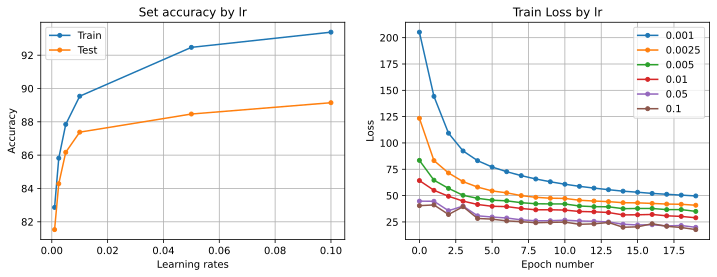

In [ ]:
plot_loss_accuracy(learning_rates,losses_by_lr,acc_by_lr,
                       'Learning rates','Accuracy','Set accuracy by lr',
                       'Epoch number','Loss','Train Loss by lr')

Para tener más elementos para seleccionar tanto la tasa de aprendizaje como el número de épocas se realizan las siguientes 4 gráficas para cada valor de la tasa de aprendizaje:
1. Exactitudes del conjunto de entrenamiento y prueba en función de las épocas.
2. Diferencia entre las exactitudes del conjunto de entrenamiento y prueba en función de las épocas.
3. Pérdidas del conjunto de entrenamiento y prueba en función de las épocas.
4. Diferencia entre las Pérdidas del conjunto de entrenamiento y prueba en función de las épocas.

Del conjunto de gráficas:
* Se confirma el problema de overfitting para `lr=0.05,0.1` ya que tanto en la exactitud como en las pérdidas el conjunto de prueba se mantiene relativamente constante a partir de la época 5 mientras que el conjunto de entrenamiento sigue mejorando, también se descartan por su comportamiento durante las primeras 5 épocas.
* Se observa que al aumentar la tasa de aprendizaje las pérdidas se separan mucho más rápido, pero en menor cantidad de épocas consiguen un valor bajo para las pérdidas.
* Al aumentar la tasa de aprendizaje la exactitud aumenta, dado que se tiene un aprendizaje más rápido.
* Para `lr=0.01` se tiene un diferencia aproximada de 1.5% de exactitud en la época 10, a partir de esa época comienza a divergir, además, en la época 10 tiene una exactitud aproximada de 85%.
* Para `lr=0.005` se tiene una exactitud aproximada de 86% en la última época, además mantiene una diferencia entre las exactitudes cercana al 1.5% en la última época.


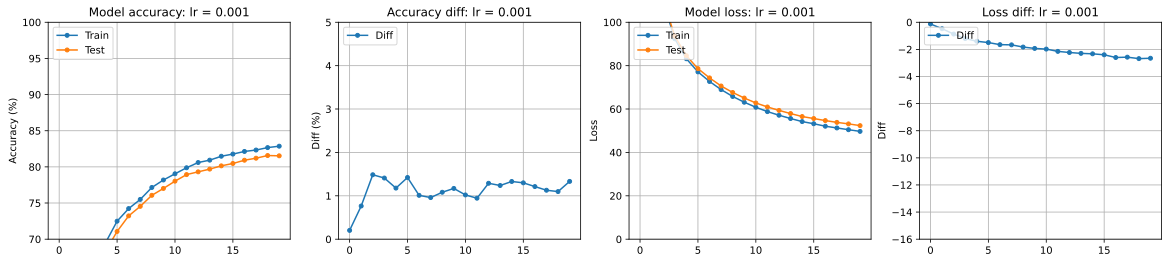

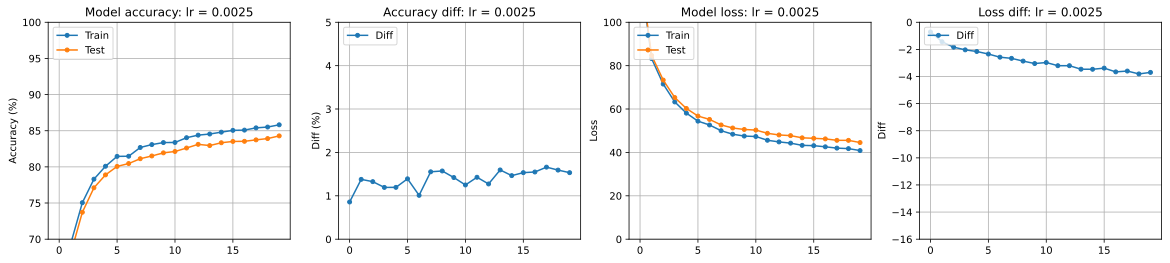

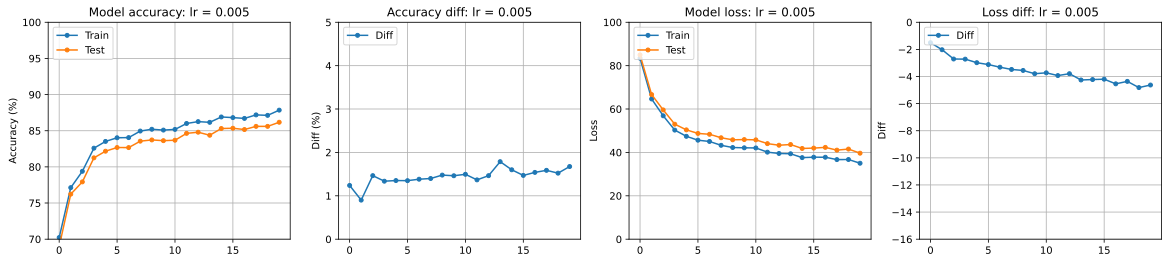

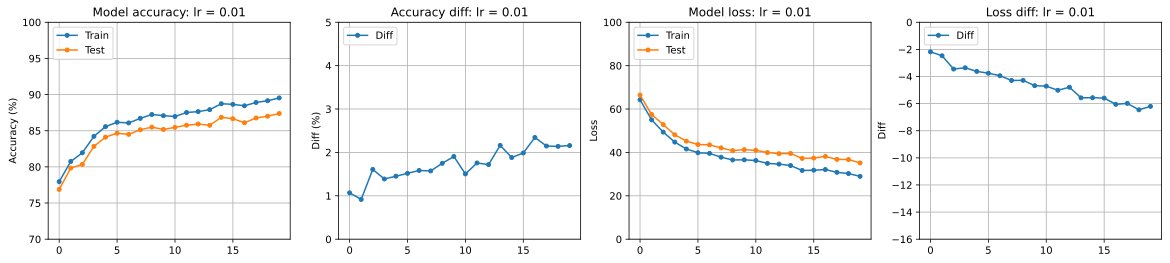

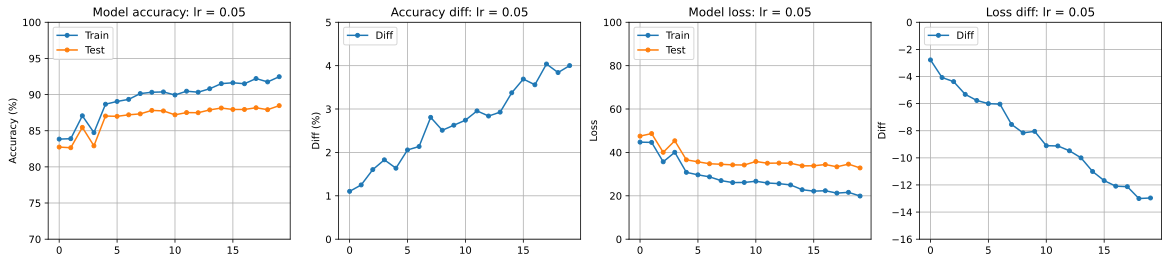

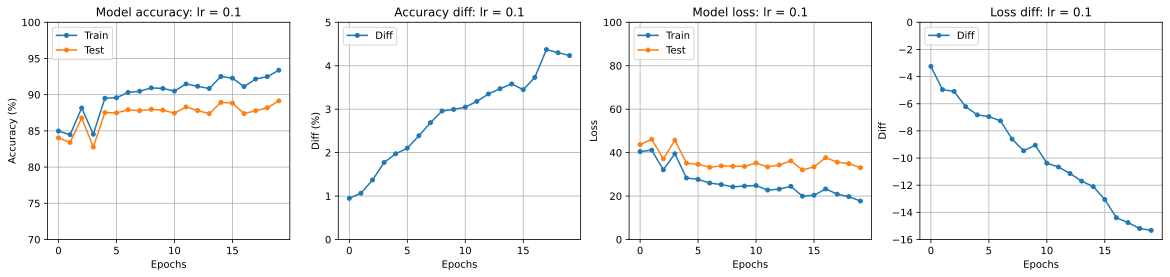

In [ ]:
plot_metrics(learning_rates,losses_by_lr,acc_by_lr,param='lr',
             acc_ylim=[70,100],dacc_ylim=[0,5],
             loss_ylim=[0,100],dloss_ylim=[-16,0])

**Se concluye utilizar una tasa de aprendizaje `lr=0.01` y número de épocas `epochs=10` para el resto de los experimentos, dado que se tiene una exactitud cercana al 86% pero con una menor cantidad de épocas, lo cual se traduce en menor tiempo de entrenamiento, y dado que se harán más experimentos, el tiempo es crucial.**

## 5.2 Variación del tamaño de lote

A continuación se realiza un experimento al variar el tamaño de lote en los valores `batch_sizes = [8,16,32,64,128,256]` del modelo base con los parámetros de tasa de aprendizaje y épocas obtenidos en el ejercicio anterior. Para cada experimento se guardan las exactitudes y pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas. El objetivo del experimento es encontrar el tamaño de lote adecuado para el problema.

In [ ]:
# generar una lista con los tamaños de lote a iterar
batch_sizes = [8,16,32,64,128,256]

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_batch = []
acc_by_batch = []
time_per_batch = []

# iterar sobre los tamaños de lote
for i in trange(len(batch_sizes)):
  # inicializar tiempo
  start = time.time()
  # entrenar modelo
  loss_hist_batch, accuracy_hist_batch, _ = train_model(create_FCN, train_data, test_data, 
                                               lr=0.01, epochs=10,
                                               batch_size=batch_sizes[i],
                                               progress=False)
  
  # calcular tiempo de ejecucion y actualizar lista
  execution_time = time.time() - start # en segundos
  time_per_batch.append(execution_time)

  # actualizar lista de accuracy por tamaño de lote
  train_acc_batch, test_accs_batch = zip(*accuracy_hist_batch)
  acc_by_batch.append([train_acc_batch, test_accs_batch])

  # obtener las perdidas para cada tamaño de lote
  train_loss_batch, test_loss_batch = zip(*loss_hist_batch)
  losses_by_batch.append([train_loss_batch,test_loss_batch])

  0%|          | 0/6 [00:00<?, ?it/s]

A continuación se muestran las siguientes gráficas:
1. Exactitudes del conjunto de entrenamiento y prueba para la última época en función del tamaño de lote.
2. Pérdidas del conjunto de entrenamiento en función de las épocas en función del tamaño de lote.
3. Tiempo de ejecución en segundos del entrenamiento en función del tamaño de lote.

De las gráficas:
* Se observa que para valores altos del tamaño de lote el tiempo de entrenamiento es menor, i.e., es más rápido el entrenamiento pero no converge tan rápido, que se muestra en la gráfica de exactitudes, a medida que aumenta el tamaño de lote, la exactitud disminuye, por lo tanto, una opción sería aumentar el número de épocas.
* Para valores pequeños del tamaño de lote se entrena más despacio pero converger más rápido, es por eso que mejores exactitudes se tienen en tamaños de lotes más pequeños.
* Para `batch_size=8` se tiene la mejor exactitud, pero es el que más tiempo de entrenamiento toma, además la diferencia entre la exactitud respecto a `batch_size=16` es muy pequeña, y además toma mucho más tiempo, por lo tanto, un `batch_size=8` queda descartado.
* Dado que le falta más tiempo de entrenamiento a `batch_size=128,256` se descartan.
* Dado que la exactitud de `batch_size=64` es menor que el caso base de `batch_size=32`, también se descarta.
* Por lo tanto, los tamaños de lotes candidatos son `batch_size=16,32`

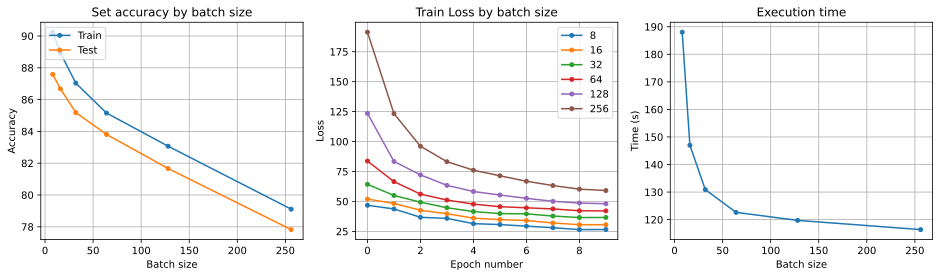

In [ ]:
plot_loss_accuracy(batch_sizes,losses_by_batch,acc_by_batch,
                       'Batch size','Accuracy','Set accuracy by batch size',
                       'Epoch number','Loss','Train Loss by batch size',
                        time_list=time_per_batch)

Para tener más elementos para seleccionar el tamaño de lote se realizan las siguientes 4 gráficas para cada valor de la tasa de aprendizaje:
1. Exactitudes del conjunto de entrenamiento y prueba en función del tamaño de lote.
2. Diferencia entre las exactitudes del conjunto de entrenamiento y prueba en función de las épocas.
3. Pérdidas del conjunto de entrenamiento y prueba en función del tamaño de lote.
4. Diferencia entre las Pérdidas del conjunto de entrenamiento y prueba en función de las épocas.

Del conjunto de gráficas:
* La mayor exactitud alcanzada en el conjunto de prueba para un `batch_size=32` es de aproximadamente 85%, mientras que para un `batch_size=16` es de aproximadamente de 87%, se observa que en la época 8 los conjuntos tienen una diferencia de 2%, y prácticamente la exactitud del conjunto de prueba es el mismo que la época siguiente.

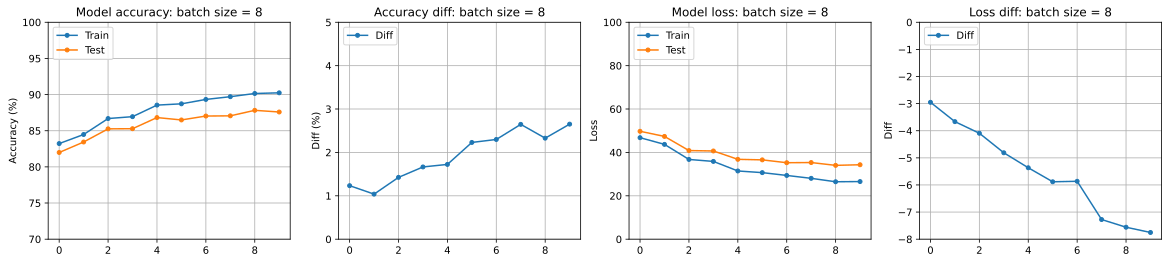

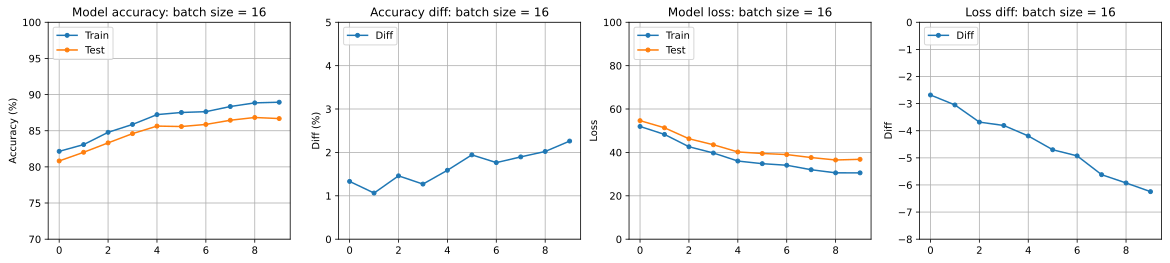

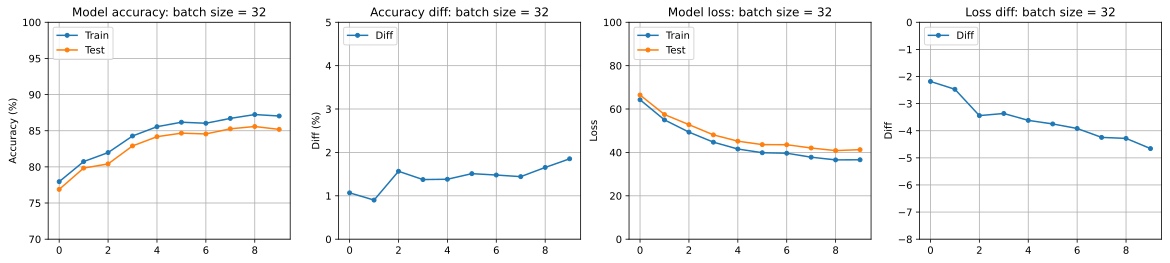

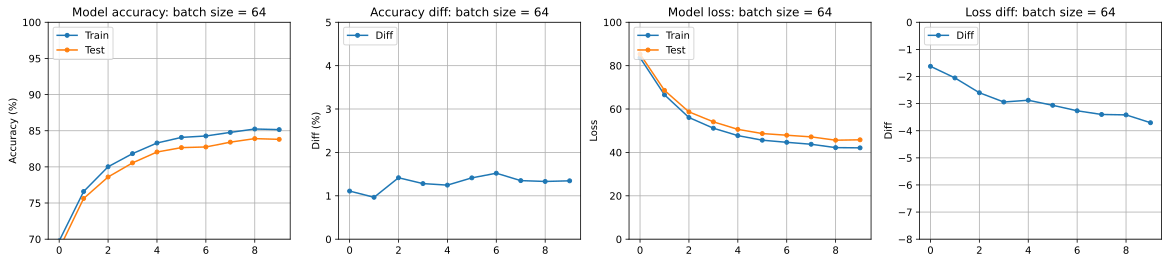

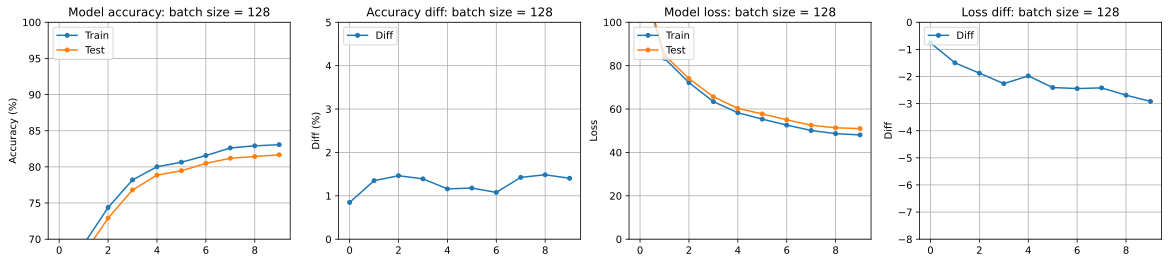

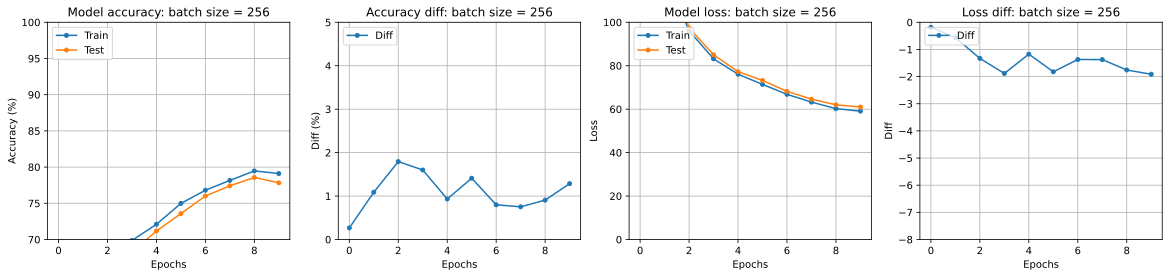

In [ ]:
plot_metrics(batch_sizes,losses_by_batch,acc_by_batch,param='batch size',
             acc_ylim=[70,100],dacc_ylim=[0,5],
             loss_ylim=[0,100],dloss_ylim=[-8,0])

**Se concluye utilizar un tamaño de lote `batch_size=16 ` y número de épocas `epochs=8` para el resto de los experimentos, dado que se tiene una exactitud cercana al 87%, un incremento en la exactitud a costa de incrementar un poco el tiempo de entrenamiento.**

## 5.3 Variación de las funciones de activación

A continuación se realiza un experimento al variar las funciones de activación `activation_functions = ['ReLU', 'Sigmoid', 'tanh']` en las capas ocultas del modelo base con los parámetros de tasa de aprendizaje, épocas, tamaño de lote obtenidos los experimentos anteriores. Para cada experimento se guardan las exactitudes y pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas. El objetivo del experimento es definir la función de activación que mejor se ajuste al problema.

In [ ]:
 # generar una lista con las funciones de activacion a iterar
activation_functions = ['ReLU', 'Sigmoid', 'tanh']

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_af = []
acc_by_af = []
time_per_af = []

# iterar sobre los tamaños de lote
for i in trange(len(activation_functions)):
  # inicializar tiempo
  start = time.time()
  # entrenar modelo
  loss_hist_af, accuracy_hist_af, _ = train_model(create_FCN, train_data, test_data, 
                                               lr=0.01, epochs=9,
                                               batch_size=16,
                                               activation_function = activation_functions[i],
                                               progress=False)
  
  # calcular tiempo de ejecucion y actualizar lista
  execution_time = time.time() - start # en segundos
  time_per_af.append(execution_time)

  # actualizar lista de accuracy por funcion de activacion
  train_acc_af, test_accs_af = zip(*accuracy_hist_af)
  acc_by_af.append([train_acc_af, test_accs_af])

  # obtener las perdidas por funcion de activacion
  train_loss_af, test_loss_af = zip(*loss_hist_af)
  losses_by_af.append([train_loss_af,test_loss_af])

  0%|          | 0/3 [00:00<?, ?it/s]

A continuación se muestran las siguientes gráficas:
1. Exactitudes del conjunto de entrenamiento y prueba para la última época en función de la función de activación.
2. Pérdidas del conjunto de entrenamiento en función de las épocas y de la función de activación.

De las gráficas:
* Las exactitudes en el conjutno de prueba de las funciones de activación ReLU (86.84%) y tanh (86.38%) son muy parecidas, pero se desempeña mejor ReLU, y se observa que tiene una menor pérdida al finalizar el entrenamiento.
* La función sigmoide tiene un peor desempeño, con una exactitud del conjunto de entrenamiento de 79.55%, esto dado que es una función saturada y no permite que fluya el gradiente dado que las derivadas se hacen cero, y eso hace que se tarde más en el entrenamiento, y eso se observa en las pérdidas.

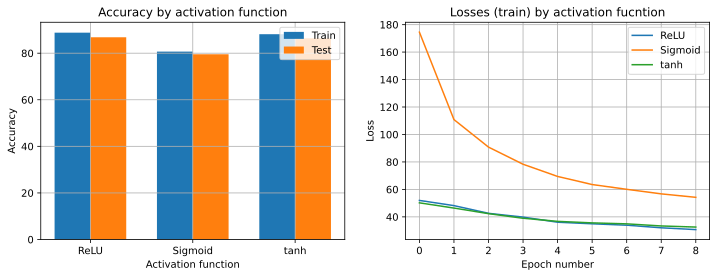

In [ ]:
plot_af(activation_functions,losses_by_af,acc_by_af)

**Se concluye utilizar la función de activación ReLU para las capas ocultas para el resto de los experimentos, dado que se tiene una mejor exactitud respecto a las otras funciones de activación.**

## 5.4 Variación de los optimizadores

A continuación se realiza un experimento al variar dos hiperparámetros, el optimizador `optim_types = ['SGD','RMSprop','Adam']` y la tasa de aprendizaje `learning_rates = [0.001,0.0025,0.005,0.01,0.05,0.1]` del modelo base con los parámetros de tasa de aprendizaje, épocas, tamaño de lote y función de activación obtenidos de los experimentos anteriores. Para cada experimento se guardan las exactitudes y pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas. El objetivo del experimento es definir el mejor optimizador y si es el caso, la tasa de aprendizaje.

In [ ]:
# generar una lista con los lr y optimizadores a iterar
learning_rates = [0.001,0.0025,0.005,0.01,0.05,0.1]
optim_types = ['SGD','RMSprop','Adam']

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_optim = []
acc_by_optim = []
time_per_optim = []

# iterar sobre los optimizadores
for i in trange(len(optim_types)):
  # iterar sobre los lr
  for j in trange(len(learning_rates)):
    # obtener optimizador y lr
    opt = optim_types[i]
    l_rate = learning_rates[j]

    # inicializar tiempo
    start = time.time()
    # entrenar modelo
    loss_hist_optim, accuracy_hist_optim, _ = train_model(create_FCN, train_data, test_data, 
                                                lr=l_rate, epochs=9,
                                                batch_size=16,
                                                activation_function ='ReLU',
                                                opt=opt,
                                                progress=False)
    
    # calcular tiempo de ejecucion y actualizar lista
    execution_time = time.time() - start # en segundos
    time_per_optim.append([opt,l_rate,execution_time])

    # actualizar lista de accuracy por funcion de activacion
    train_acc_optim, test_accs_optim = zip(*accuracy_hist_optim)
    acc_by_optim.append([opt,l_rate,train_acc_optim, test_accs_optim])

    # obtener las perdidas por funcion de activacion
    train_loss_optim, test_loss_optim = zip(*loss_hist_optim)
    losses_by_optim.append([opt,l_rate,train_loss_optim,test_loss_optim])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

A continuación se muestran las siguientes gráficas:
1. La exactitud alcanzada por optimizador en la última época de entrenamiento para el conjunto de entrenamiento en función de la tasa de aprendizaje.
2. La exactitud alcanzada por optimizador en la última época de entrenamiento para el conjunto de prueba en función de la tasa de aprendizaje.
3. El tiempo de ejecución por optimizador en función de la tasa de aprendizaje.

De las gráficas se observa que:
* SGD tiene una mejor exacitud para tasas de aprendizaje mayores, pero no para tasas de aprendizaje menores, esto es porque tarda más en aprender y necesita una mayor cantidad de épocas.
* Mientras que ADAM y RMSprop tienen el comportamiento contrario, ajustan mejor con tasas de aprendizaje menores, dado que ambos optimizadores modifican la tasa de aprendizaje de manera dinámica según el comportamiento del modelo, es por eso que es mejor inicializar con valores pequeños la tasa de aprendizaje.
* El tiempo de ejecución es mayor para RMSprop, y dado que Adam tiene mejores exactitudes, se prefiere Adam sobre RMSprop.
* La máxima exactitud alcanzada por Adam es parecida a la alcanzada con SGD, pero como se observó en experimentos anteriores, un `lr=0.01` para SGD daba pie a overfitting, por lo tanto se decide utilizar el optimizador Adam.
* Ahora bien, para definir la tasa de aprendizaje adecuada se decide realizar una inspección visual con mayor profundidad de las distintas tasas de aprendizaje empleando el optimizador Adam.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  # Remove the CWD from sys.path while we load stuff.


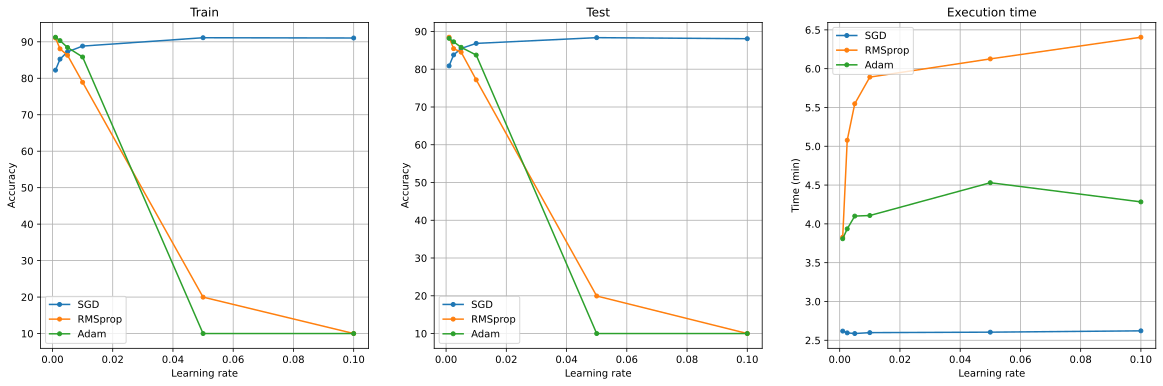

In [ ]:
plot_acc_2param(acc_by_optim,learning_rates,optim_types,time_list=time_per_optim,
                x_label='Learning rate',y_label='Accuracy')

En esta sección de código lo que se realiza es filtrar los resultados del experimento anterior tal que solo se tengan los resultados con el optimizador Adam, además de modificar las estructuras de datos a modo que se puedan graficar las exactitudes y pérdidas en función de las épocas.

In [ ]:
# convertir a numpy arrays las listas con las metricas
losses_np = np.array(losses_by_optim)
acc_np = np.array(acc_by_optim)
# filtrar para obtener los valores de Adam
losses_adam = losses_np[losses_np[:,0] == 'Adam']
acc_adam = acc_np[acc_np[:,0] == 'Adam']
# obtener los valores de la metrica del conjunto de entrenamiento y prueba
losses_adam = separate_train_test(losses_adam,learning_rates)
acc_adam = separate_train_test(acc_adam,learning_rates)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until


Para tener más elementos para seleccionar tanto la tasa de aprendizaje se realizan las siguientes 4 gráficas para cada valor de la tasa de aprendizaje y el optimizador Adam:
1. Exactitudes del conjunto de entrenamiento y prueba en función de las épocas.
2. Diferencia entre las exactitudes del conjunto de entrenamiento y prueba en función de las épocas.
3. Pérdidas del conjunto de entrenamiento y prueba en función de las épocas.
4. Diferencia entre las Pérdidas del conjunto de entrenamiento y prueba en función de las épocas.

Del conjunto de gráficas:
* La exactitud es mejor al tener una tasa de aprendizaje menor, por lo tanto `lr=0.001` es una buena opción, ya que la exactitud es la mejor y es cercana al 88%, también se observa un riesgo de overfitting a partir de la época 4, pero para realizar los siguientes experimento se dejará un entrenamiento de 10 épocas, con la atención del riesgo de oberfitting.

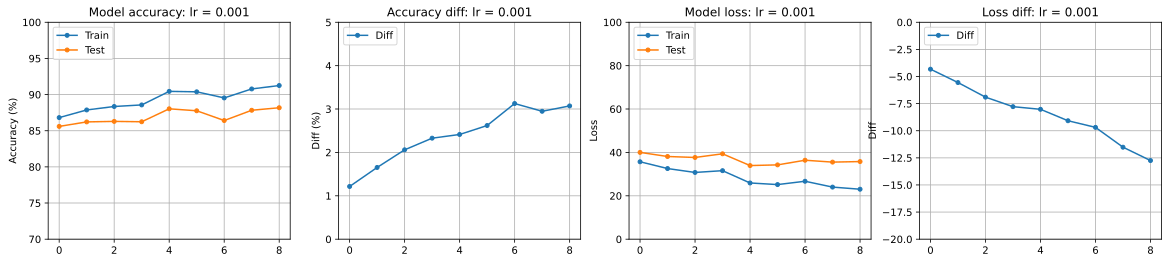

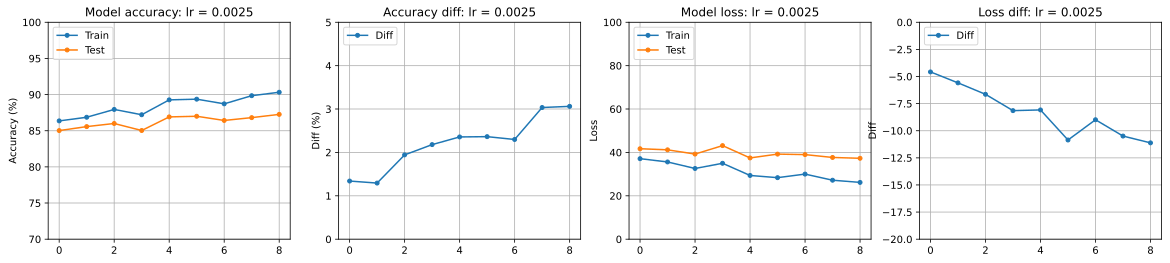

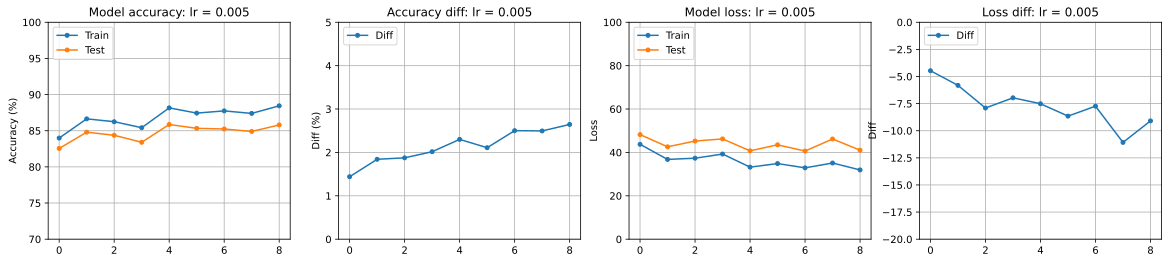

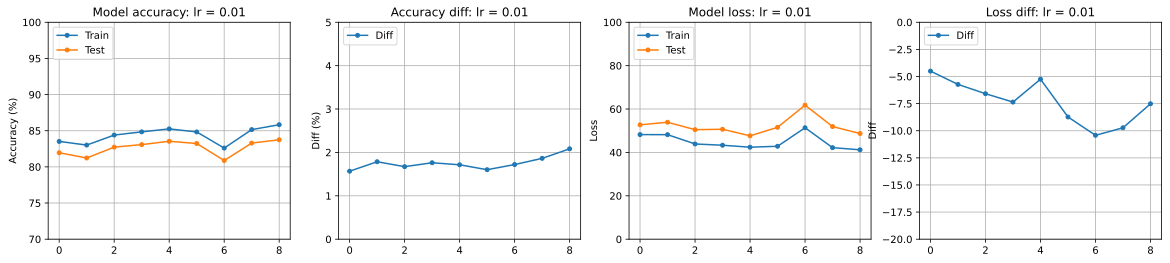

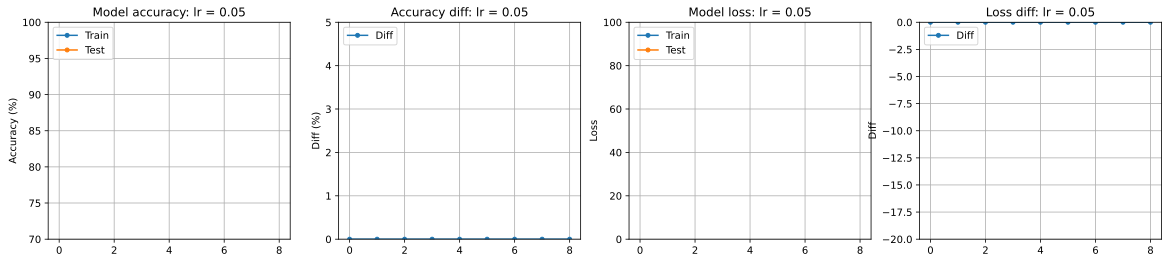

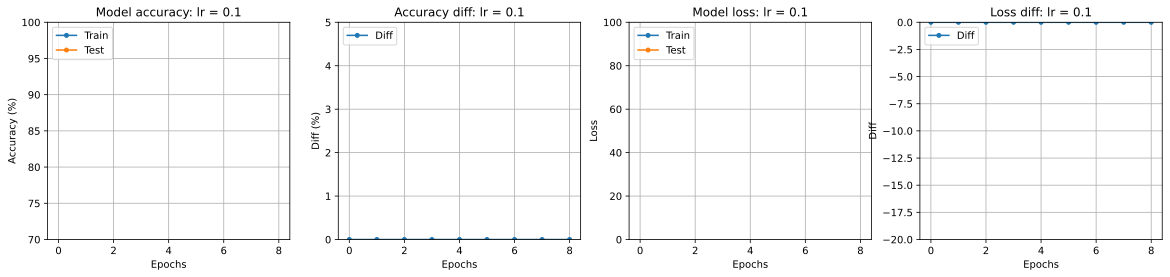

In [ ]:
plot_metrics(learning_rates,losses_adam,acc_adam,param='lr',
             acc_ylim=[70,100],dacc_ylim=[0,5],
             loss_ylim=[0,100],dloss_ylim=[-20,0])

**Se concluye utilizar el optimizador Adam con una tasa de aprendizaje `lr=0.001` para el resto de los experimentos, dado que se tiene una mejor exactitud.**

## 5.5 Variación de anchura y profundidad

A continuación se realiza un experimento variando la profundidad (número de neuronas en las capas ocultas `numunits = [1,2,3]`) y anchura (número de capas ocultas `numlayers = [50,100,150,200,250]`) de la red neuronal del modelo base con los parámetros de tasa de aprendizaje, épocas, tamaño de lote, función de activación y optimizador obtenidos de los experimentos anteriores. Para cada experimento se guardan las exactitudes y pérdidas de los conjuntos de entrenamiento y prueba en función de las épocas. El objetivo del experimento es definir la profundidad y anchur de la red.

In [ ]:
# generar una lista con el numero de capas ocultas a iterar 
# y el numero de neuronas por capa
numlayers = range(1,4)           # numero de capas ocultas (1,2,3)
numunits  = np.arange(50,251,50) # numero de neuronas por capa oculta

# inicializar listas para guardar los resultados de perdida, accuracy y tiempo de ejecucion
losses_by_exp = []
acc_by_exp = []
time_per_exp = []

# iterar sobre el numero de neuronas
for i in trange(len(numunits)):
  # iterar sobre el numero de capas
  for j in trange(len(numlayers)):
    # obtener numero de neuronas y capas
    n_units = numunits[i]
    n_layers = numlayers[j]

    # inicializar tiempo
    start = time.time()
    # entrenar modelo
    loss_hist_exp, accuracy_hist_exp, _ = train_model(create_FCN, train_data, test_data, 
                                                lr=0.001, epochs=9,
                                                batch_size=16,
                                                activation_function ='ReLU',
                                                opt='Adam',
                                                n_layers=n_layers,
                                                n_neurons=n_units,
                                                progress=False)
    
    # calcular tiempo de ejecucion y actualizar lista
    execution_time = time.time() - start # en segundos
    time_per_exp.append([n_layers,n_units,execution_time])

    # actualizar lista de accuracy por funcion de activacion
    train_acc_exp, test_accs_exp = zip(*accuracy_hist_exp)
    acc_by_exp.append([n_layers,n_units,train_acc_exp, test_accs_exp])

    # obtener las perdidas por funcion de activacion
    train_loss_exp, test_loss_exp = zip(*loss_hist_exp)
    losses_by_exp.append([n_layers,n_units,train_loss_exp,test_loss_exp])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

A continuación se muestran las siguientes gráficas:
1. La exactitud alcanzada por número de capas ocultas en la última época de entrenamiento para el conjunto de entrenamiento en función del número de neuronas en las capas ocultas.
2. La exactitud alcanzada por número de capas ocultas en la última época de entrenamiento para el conjunto de prueba en función del número de neuronas en las capas ocultas.
3. El tiempo de ejecución por número de capas ocultas en función del número de neuronas en las capas ocultas.

De las gráficas se observa que:
* La exactitud del modelo base con todas las modificaciones es de 88.18% en el conjunto de entrenamiento, y las arquitecturas que lo superan son:
  * 1 capa oculta con 200 neuronas ocultas
  * 1 capa oculta con 250 neuronas ocultas
  * 3 capas ocultas con 250 neuronas ocultas
* El tiempo de ejecución aumenta conforme aumenta la complejidad dado que se aumentan la cantidad de parámetros que se tienen que aprender.
* Dicho aumento implica una sobreparametrización, lo que da lugar al overfitting, que se observa en especial en los casos con 250 neuronas en las capas ocultas.
* Dado que la mayor mejora que se podría tener con este experimento es de 88.42%, i.e., una mejora de 0.24%, incrementando de 2 a 4 minutos de entrenamiento y con el riesgo de overfitting, se concluye que es mejor dejar la arquitectura base.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


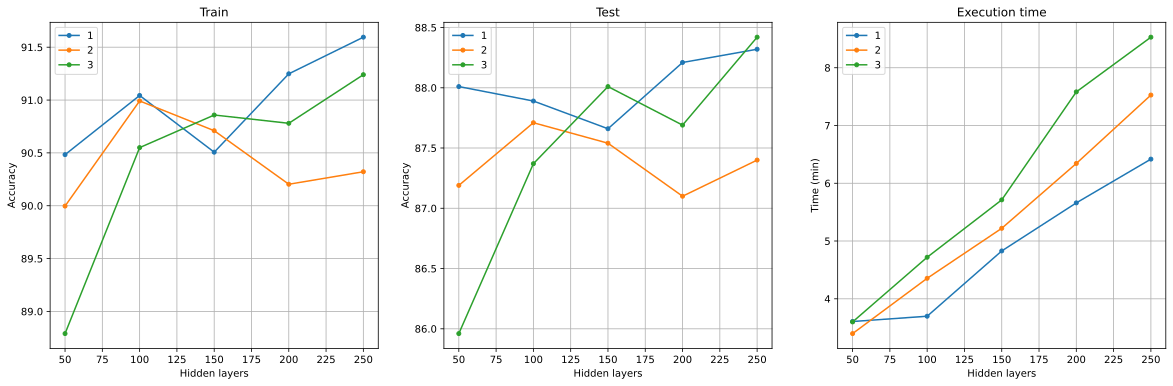

In [ ]:
plot_acc_2param(acc_by_exp,numunits,numlayers,time_list=time_per_exp,
                x_label='Hidden layers',y_label='Accuracy')

**Se concluye utilizar una capa oculta con 128 neuronas, dado que se tiene una exactitud buena, con menor tiempo de entrenamiento y menor riesgo de overfitting.**

# 6 Arquitectura final

La conclusión de todos los experimentos realizados es utilizar una arquitectura:
1. Aplanar en el primer paso
2. Una capa oculta con 128 neuronas
3. Utilizar ReLU como función de activación
4. Utilizar Adam como optimizador
5. Utilizar una tasa de aprendizaje de 0.001
6. Utilizar un tamaño de lote de 16
7. Entrenar por 6 épocas

## 6.1 Entrenamiento

A continuación se realiza el entrenamiento de la arquitectura final:

In [ ]:
loss_hist, accuracy_hist, model_f = train_model(create_FCN, train_data, test_data, 
                                                lr=0.001, epochs=6,
                                                batch_size=16,
                                                activation_function ='ReLU',
                                                opt='Adam',
                                                n_layers=1,
                                                n_neurons=128,
                                                progress=True,
                                                verbose_summary=True)

Layer (type:depth-idx)                   Input Shape               Output Shape
FCN                                      [16, 28, 28]              [16, 10]
├─ModuleDict: 1-1                        --                        --
│    └─Flatten: 2-1                      [16, 28, 28]              [16, 784]
│    └─Linear: 2-2                       [16, 784]                 [16, 128]
│    └─Linear: 2-3                       [16, 128]                 [16, 128]
│    └─Linear: 2-4                       [16, 128]                 [16, 10]
Total params: 118,282
Trainable params: 118,282
Non-trainable params: 0
Total mult-adds (M): 1.89
Input size (MB): 0.05
Forward/backward pass size (MB): 0.03
Params size (MB): 0.47
Estimated Total Size (MB): 0.56


  0%|          | 0/6 [00:00<?, ?it/s]

E00 loss=[ 38.46, 42.96] acc=[86.04,85.08]
E01 loss=[ 33.49, 38.94] acc=[87.68,85.87]
E02 loss=[ 30.91, 36.86] acc=[88.63,86.66]
E03 loss=[ 28.81, 37.02] acc=[89.21,86.53]
E04 loss=[ 26.10, 35.04] acc=[90.30,87.85]
E05 loss=[ 24.84, 34.21] acc=[90.59,88.18]


## 6.2 Visualización de resultados

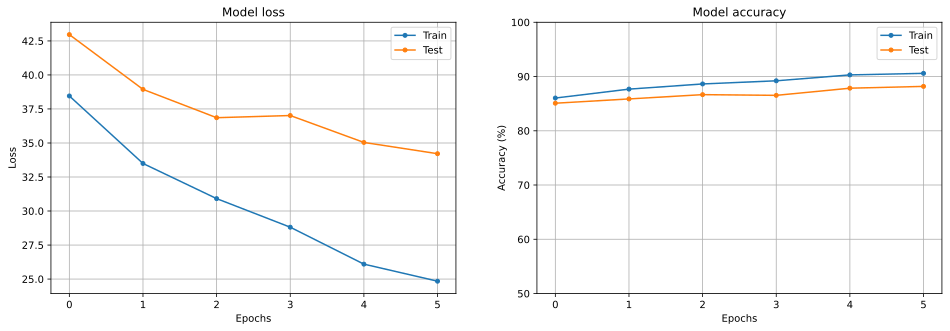

In [ ]:
train_loss, test_loss = zip(*loss_hist)
train_acc, test_acc = zip(*accuracy_hist)

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(train_loss,label='Train',marker=MARKER,markersize=MARKER_SIZE)
ax[0].plot(test_loss,label='Test',marker=MARKER,markersize=MARKER_SIZE)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model loss')
ax[0].grid()
ax[0].legend()

ax[1].plot(train_acc,label='Train',marker=MARKER,markersize=MARKER_SIZE)
ax[1].plot(test_acc,label='Test',marker=MARKER,markersize=MARKER_SIZE)
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title('Model accuracy')
ax[1].set_ylim([50,100])
ax[1].grid()
ax[1].legend()

plt.show()

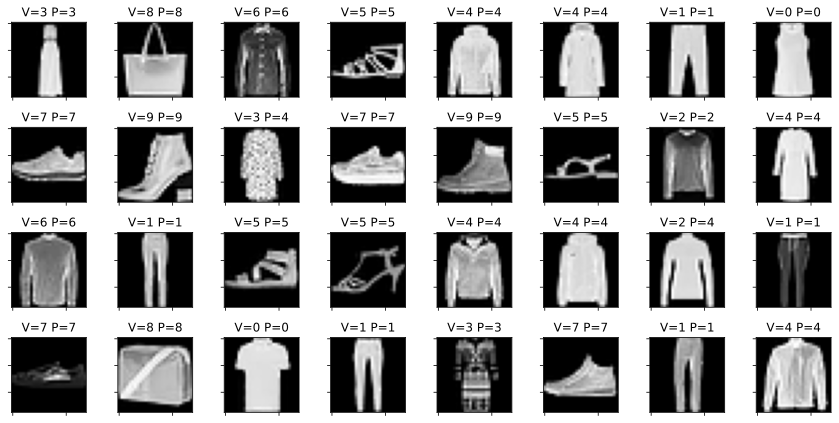

In [ ]:
# inferencia
with torch.no_grad(): 
    x, y_true = next(iter(test_loader))
    y_hat = model_f(x)
    y_prob = F.softmax(y_hat, 1)
    y_pred = torch.argmax(y_prob, 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    display_batch(x, titles, ROWS, COLS)

La exactitud del modelo resultó de 88.18%, y del lote de prueba, se observa que el modelo se equivoca en 2, los cuales los infiere como abrigo, pero son una sudadera y un vestido respectivamente.